TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'stoch12', 'stochDiff6012', 'RSIhl_diff', 'RSIhl_diffROC', 'vol',
       'vol10', 'vol15', 'vol30', 'ToD', 'DoW', 'MO'],
      dtype='object')
TESTING FOR: 
Dr3
X shape == (1572, 24, 19).
y shape == (1572, 1).
-0.023514790897871552
1.519754835858698
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


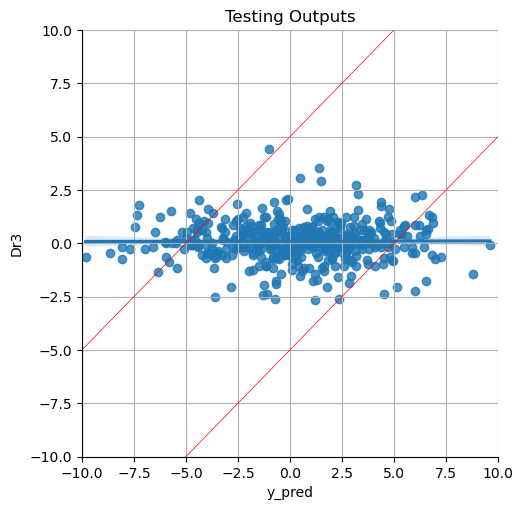

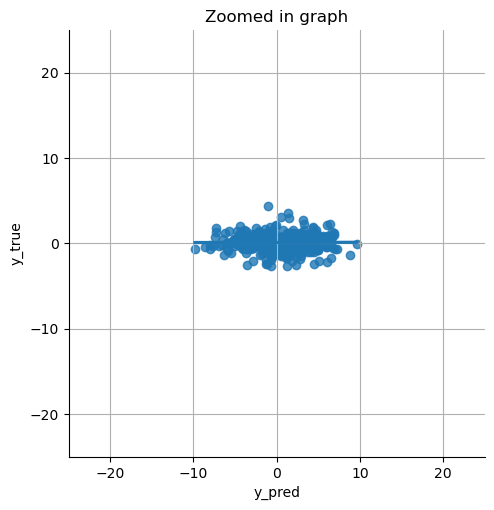

Directional Accuracy:		 50.0
Directional Accuracy >(+/-)5:	 57.14


In [76]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted__6dayTest_1.csv')
dataTRAIN = pd.read_csv('catted_1.csv')

#      'Dr1' 'Dr3' 'Mr1' 'Mr3' 
testFor = 'Dr3'
timeSteps = 24
tType = testFor[0]
#testing random feature drops
#TREND

data = data.drop(columns='FT')
data = data.drop(columns='FT.1')
data = data.drop(columns='FT.2')
data = data.drop(columns='YM_diff')
data = data.drop(columns='NQ_diff')
data = data.drop(columns='volNQdiff')
data = data.drop(columns='volYMdiff')
dataTRAIN = dataTRAIN.drop(columns='FT')
dataTRAIN = dataTRAIN.drop(columns='FT.1')
dataTRAIN = dataTRAIN.drop(columns='FT.2')
dataTRAIN = dataTRAIN.drop(columns='YM_diff')
dataTRAIN = dataTRAIN.drop(columns='NQ_diff')
dataTRAIN = dataTRAIN.drop(columns='volNQdiff')
dataTRAIN = dataTRAIN.drop(columns='volYMdiff')

data = data.drop(columns='vol60')
data = data.drop(columns='volD10')
data = data.drop(columns='volD15')
data = data.drop(columns='volD30')
data = data.drop(columns='volD60')
data = data.drop(columns='vpm5')
data = data.drop(columns='vpm10')
data = data.drop(columns='vpm15')
data = data.drop(columns='vpm30')
data = data.drop(columns='vpm60')
data = data.drop(columns='acc30')
data = data.drop(columns='acc60')
dataTRAIN = dataTRAIN.drop(columns='vol60')
dataTRAIN = dataTRAIN.drop(columns='volD10')
dataTRAIN = dataTRAIN.drop(columns='volD15')
dataTRAIN = dataTRAIN.drop(columns='volD30')
dataTRAIN = dataTRAIN.drop(columns='volD60')
dataTRAIN = dataTRAIN.drop(columns='vpm5')
dataTRAIN = dataTRAIN.drop(columns='vpm10')
dataTRAIN = dataTRAIN.drop(columns='vpm15')
dataTRAIN = dataTRAIN.drop(columns='vpm30')
dataTRAIN = dataTRAIN.drop(columns='vpm60')
dataTRAIN = dataTRAIN.drop(columns='acc30')
dataTRAIN = dataTRAIN.drop(columns='acc60')


#CALENDAR
#--------------------------------------
#SOLUTION------------------------------
data = data.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
dataTRAIN = dataTRAIN.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
match testFor:
    case 'Dr1':
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Dr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Mr1':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Mr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')


#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

XTRAIN = dataTRAIN.iloc[:, :-1].values
yTRAIN = dataTRAIN.iloc[:, -1].values

# Standardize the features
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = MinMaxScaler(feature_range=(-1,1))

percFit = 0.8
fitSplit = len(X)//(1/(percFit))
negFitSplit = len(X)//(1/(1-percFit))

scaler1.fit(XTRAIN)
XTRAIN = scaler1.transform(XTRAIN)
#scaler2.fit(XTRAIN)
#XTRAIN = scaler2.transform(XTRAIN)
#scaler3.fit(XTRAIN)
#XTRAIN = scaler3.transform(XTRAIN)
X = scaler1.transform(X)
#X = scaler2.transform(X)
#X = scaler3.transform(X)
#scaler3.fit(XTRAIN)


#X = scaler3.transform(X)

#setting data for LSTM
def reformat_to_lstm(dat, time_steps=timeSteps):
    X_lstm, y_lstm = [], []
    
    for i in range(time_steps, len(dat)+1):
        # Collect previous time_steps rows for X
        X_lstm.append(dat[i-time_steps:i])  
        # The corresponding y value for the last time step in the sequence
    
    X_lstm = np.array(X_lstm)
    
    return X_lstm
#setting data for LSTM digitalScreeni code
def screeni_to_lstm(dat, time_steps=timeSteps):
    X_lstm, y_lstm = [], []
    
    for i in range(time_steps, len(dat)):
        X_lstm.append(dat[i-time_steps:i, 0:dat.shape[1]])
        y_lstm.append(dat[i:i+1,0])
    
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    
    return X_lstm, y_lstm

X, y = screeni_to_lstm(X, timeSteps)

print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))

XTRAIN, yTRAIN = screeni_to_lstm(XTRAIN, timeSteps)

mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
print(mos)

def remove_zero_mo_samples(X, y):
    # Get the 'MO' column (index 34 for 0-based indexing) for all time steps and samples
    non_zero_indices = (X[:, timeSteps-1, len(Xfeatures)-1] >= 0)
    # Filter X and y using these indices
    X_filtered = X[non_zero_indices]
    y_filtered = y[non_zero_indices]
    return X_filtered, y_filtered

X, y = remove_zero_mo_samples(X, y)
XTRAIN, yTRAIN = remove_zero_mo_samples(XTRAIN, yTRAIN)

mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
print(mos)

loaded_model = tf.keras.models.load_model('LSTM_Dr3_24step_7.keras')
loaded_model.compile(optimizer='adam',
                  loss='mse'
                  ,metrics=['R2Score','root_mean_squared_error'])

#predicting the test set results
y_pred = loaded_model.predict(X) 

import seaborn as sns
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y})
#data.insert(1, "y_pred", y_pred, True)
# plot 1 with axes level-plot
g = sns.lmplot(data=ys,x="y_pred", y="y_true")#, hue="MO")

#plt.scatter(y_pred, y, s=1)
plt.axis('tight')
plt.grid()
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.ylabel(testFor)

# Get the current axes from the lmplot
ax = plt.gca()

# Define the limits for the line (should cover the same range as your plot)
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x

# Plot the y=x line
plt.plot(x_vals+5, y_vals, '-', color='red', label='y = x', linewidth=0.5)
plt.plot(x_vals-5, y_vals, '-', color='red', label='y = x', linewidth=0.5)

match tType:
    case 'D':
        plt.xlim(-10,10)
        plt.ylim(-10,10)
    case _:
        plt.xlim(0,5)
        plt.ylim(0,5)
plt.show()

g = sns.lmplot(data=ys,x="y_pred", y="y_true")#,hue="MO")
plt.title('Zoomed in graph')
plt.grid()
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.show()

#DIRECTIONAL ACCURACY #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  
tp, fp, tn, fn = 0, 0, 0, 0
tp5, fp5, tn5, fn5 = 0, 0, 0, 0
y_pred = ys['y_pred']
y_test = ys['y_true']
for i in range(len(y_pred)):
    if(y_pred[i]>0):
        if(y_test[i]>0):
            tp+=1
        if(y_test[i]<0):
            fp+=1
        if(y_pred[i]>=5):
            if(y_test[i]>0):
                tp5+=1
            if(y_test[i]<0):
                fp5+=1
    if(y_pred[i]<0):
        if(y_test[i]<0):
            tn+=1
        if(y_test[i]>0):
            fn+=1
        if(y_pred[i]<=-5):
            if(y_test[i]<0):
                tn5+=1
            if(y_test[i]>0):
                fn5+=1
directionalAccuracy = ((tp+tn)/(tp+fp+tn+fn))*10000//1/100
directionalAccuracy5guess = ((tp5+tn5)/(tp5+fp5+tn5+fn5))*10000//1/100
print('Directional Accuracy:\t\t',directionalAccuracy)
print('Directional Accuracy >(+/-)5:\t',directionalAccuracy5guess)

In [72]:
data.corr()
#print(X.shape)

,vel5,vel10,vel15,vel30,vel60,acc5,acc10,acc15,stoch12,stochDiff6012,RSIhl_diff,RSIhl_diffROC,vol,vol10,vol15,vol30,ToD,DoW,MO,Dr3
vel5,1.000000,0.687578,0.575269,0.407828,0.289817,0.725868,0.477775,0.408135,0.418945,0.447791,0.007745,-0.037587,-0.041732,-0.033557,-0.008782,0.011684,-0.005231,-0.019490,0.071790,-0.026836
vel10,0.687578,1.000000,0.804548,0.580599,0.413557,-0.000351,0.711954,0.560821,0.531850,0.557121,0.014364,-0.024077,-0.037109,-0.044364,-0.026042,0.014987,-0.007961,-0.027849,0.104274,-0.010894
vel15,0.575269,0.804548,1.000000,0.706625,0.505659,0.030115,0.286262,0.712017,0.594553,0.603481,0.002931,-0.034761,-0.005832,-0.025171,-0.022294,0.019968,-0.009207,-0.034132,0.124134,-0.011635
vel30,0.407828,0.580599,0.706625,1.000000,0.709722,0.011757,0.011864,0.006293,0.668189,0.602110,-0.043717,-0.047696,0.060555,0.046263,0.041762,0.040960,-0.008743,-0.047926,0.156879,-0.008440
vel60,0.289817,0.413557,0.505659,0.709722,1.000000,0.007468,0.005443,0.010389,0.645470,0.412078,-0.082342,-0.006216,0.158451,0.164096,0.170846,0.170275,-0.003403,-0.062528,0.192399,0.016809
acc5,0.725868,-0.000351,0.030115,0.011757,0.007468,1.000000,-0.016466,0.030724,0.073148,0.088896,-0.002900,-0.028908,-0.022241,-0.004095,0.012687,0.001997,0.000295,-0.000453,0.000124,-0.026635
acc10,0.477775,0.711954,0.286262,0.011864,0.005443,-0.016466,1.000000,0.392714,0.123511,0.170815,0.025230,-0.004328,-0.066294,-0.062953,-0.032139,-0.003047,-0.003157,-0.000108,0.012130,0.000174
acc15,0.408135,0.560821,0.712017,0.006293,0.010389,0.030724,0.392714,1.000000,0.177070,0.255132,0.047521,-0.001766,-0.068348,-0.081497,-0.072939,-0.012443,-0.004167,-0.000837,0.019844,-0.008025
stoch12,0.418945,0.531850,0.594553,0.668189,0.645470,0.073148,0.123511,0.177070,1.000000,0.744721,-0.067029,-0.024831,0.073699,0.066135,0.063692,0.058399,0.038421,-0.126219,0.195587,-0.024272
stochDiff6012,0.447791,0.557121,0.603481,0.602110,0.412078,0.088896,0.170815,0.255132,0.744721,1.000000,-0.020323,-0.046958,-0.097380,-0.118365,-0.127716,-0.132097,-0.016468,-0.017691,-0.011992,-0.036180
